In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_games = pd.read_csv("appstore_games.csv")

## Data Cleaning

In [3]:
# Dropping unneeded columns
df_games.drop(labels=["URL","ID","Subtitle","Description","Languages","Primary Genre",
                      "Original Release Date","Current Version Release Date"], axis=1, inplace=True)

In [4]:
# Replacing null values in "User Rating Count" with a value of 0
df_games["User Rating Count"].fillna(value=0, inplace=True)

In [5]:
# Change in-app purchase column to be 0 (does not have in app purchases) or 1 (does have in app purchases)
df_games["In-app Purchases"].fillna(value=0, inplace=True)
df_games["In-app Purchases"].loc[df_games["In-app Purchases"] != 0] = 1

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [6]:
# Getting rid of + signs in "Age Rating" column
df_games.loc[df_games["Age Rating"] == "4+",["Age Rating"]] = "4"
df_games.loc[df_games["Age Rating"] == "9+",["Age Rating"]] = "9"
df_games.loc[df_games["Age Rating"] == "12+",["Age Rating"]] = "12"
df_games.loc[df_games["Age Rating"] == "17+",["Age Rating"]] = "17"

In [7]:
# Final cleaned dataframe
df_games = df_games.dropna()

In [8]:
df_games

,Name,Icon URL,Average User Rating,User Rating Count,Price,In-app Purchases,Developer,Age Rating,Size,Genres
0,Sudoku,https://is2-ssl.mzstatic.com/image/thumb/Purpl...,4.0,3553.0,2.99,0,Mighty Mighty Good Games,4,15853568.0,"Games, Strategy, Puzzle"
1,Reversi,https://is4-ssl.mzstatic.com/image/thumb/Purpl...,3.5,284.0,1.99,0,Kiss The Machine,4,12328960.0,"Games, Strategy, Board"
2,Morocco,https://is5-ssl.mzstatic.com/image/thumb/Purpl...,3.0,8376.0,0.00,0,Bayou Games,4,674816.0,"Games, Board, Strategy"
3,Sudoku (Free),https://is3-ssl.mzstatic.com/image/thumb/Purpl...,3.5,190394.0,0.00,0,Mighty Mighty Good Games,4,21552128.0,"Games, Strategy, Puzzle"
4,Senet Deluxe,https://is1-ssl.mzstatic.com/image/thumb/Purpl...,3.5,28.0,2.99,0,RoGame Software,4,34689024.0,"Games, Strategy, Board, Education"
...,...,...,...,...,...,...,...,...,...,...
16950,Die Last,https://is1-ssl.mzstatic.com/image/thumb/Purpl...,3.0,6.0,0.00,0,Jie Yang,12,151308288.0,"Games, Strategy, Entertainment, Puzzle"
16956,Basic Slosh,https://is5-ssl.mzstatic.com/image/thumb/Purpl...,5.0,30.0,0.00,0,Ashnell Marchand,4,79646720.0,"Games, Entertainment, Action, Strategy"
16962,Idle Racing Tycoon,https://is2-ssl.mzstatic.com/image/thumb/Purpl...,5.0,51.0,0.00,0,Carson Brody,9,125348864.0,"Games, Simulation, Strategy"
16967,Glow Hockey Strike,https://is2-ssl.mzstatic.com/image/thumb/Purpl...,5.0,5.0,0.00,0,Samir Jabeur,4,128687104.0,"Games, Simulation, Strategy"


# K-Means

In [9]:
def plotCurrent(X, Rnk, Kmus):
    N, D = np.shape(X)
    K = np.shape(Kmus)[0]

    InitColorMat = np.matrix([[1, 0, 0], 
                              [0, 1, 0],   
                              [0, 0, 1],
                              [0, 0, 0],
                              [1, 1, 0], 
                              [1, 0, 1], 
                              [0, 1, 1]])

    KColorMat = InitColorMat[0:K]
    colorVec = Rnk.dot(KColorMat)
    muColorVec = np.eye(K).dot(KColorMat)

    plt.scatter(X[:,0], X[:,1], edgecolors=colorVec, marker='o', facecolors='none', alpha=0.3)
    plt.scatter(Kmus[:,0], Kmus[:,1], c=muColorVec, marker='D', s=50);

In [10]:
def calcSqDistances(X, Kmus):
    return ((-2 * X.dot(Kmus.T) + np.sum(np.multiply(Kmus,Kmus), axis=1).T).T + np.sum(np.multiply(X,X), axis=1)).T

In [11]:
def determineRnk(sqDmat):
    m = np.argmin(sqDmat, axis=1)
    return np.eye(sqDmat.shape[1])[m]

In [12]:
def recalcMus(X, Rnk):
    return (np.divide(X.T.dot(Rnk), np.sum(Rnk, axis=0))).T

In [13]:
def runKMeans(K, data, subset):
    X = data[subset]
    
    N = len(X)
    D = 2
    
    X = X.to_numpy()
    X = X.astype(int)

    # Allocate space for the K mu vectors
    Kmus = np.zeros((K, D))

    # Initialize cluster centers by randomly picking points from the data
    rndinds = np.random.permutation(N)
    Kmus = X[rndinds[:K]];

    # Specify the maximum number of iterations to allow
    maxiters = 1000;

    for iter in range(maxiters):
        # Assign each data vector to closest mu vector as per Bishop (9.2)
        # Do this by first calculating a squared distance matrix where the n,k entry
        # contains the squared distance from the nth data vector to the kth mu vector

        # sqDmat will be an N-by-K matrix with the n,k entry as specfied above
        sqDmat = calcSqDistances(X, Kmus);

        # given the matrix of squared distances, determine the closest cluster
        # center for each data vector 

        # R is the "responsibility" matrix
        # R will be an N-by-K matrix of binary values whose n,k entry is set 
        # Specifically, the n,k entry is 1 if point n is closest to cluster k,
        # and is 0 otherwise
        Rnk = determineRnk(sqDmat)

        KmusOld = Kmus
        plotCurrent(X, Rnk, Kmus)
        plt.show()

        # Recalculate mu values based on cluster assignments
        Kmus = recalcMus(X, Rnk)

        # Check to see if the cluster centers have converged.  If so, break.
        if sum(abs(KmusOld.flatten() - Kmus.flatten())) < 1e-6:
            break

    plotCurrent(X,Rnk,Kmus)

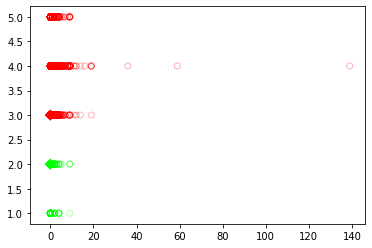

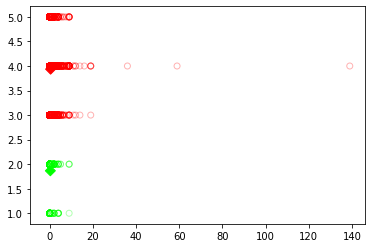

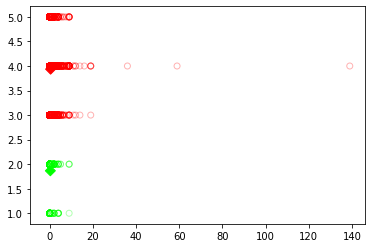

In [14]:
runKMeans(2, df_games, ["Price", "Average User Rating"]) 

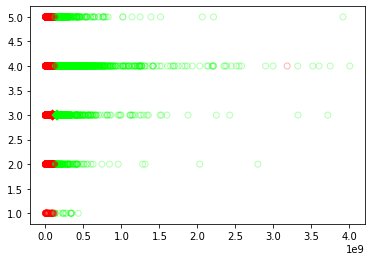

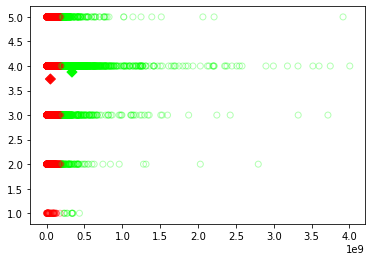

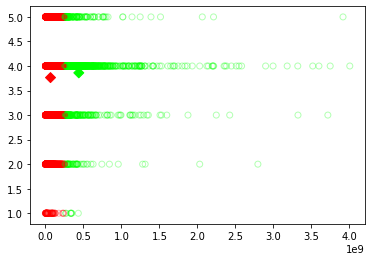

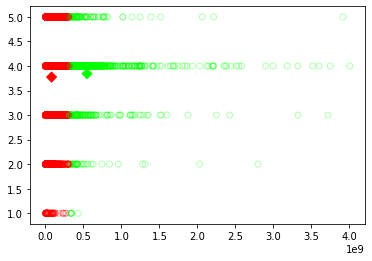

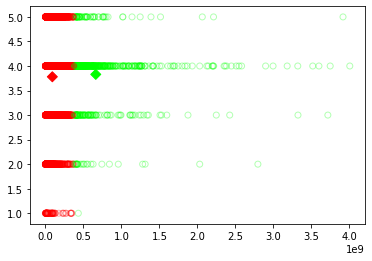

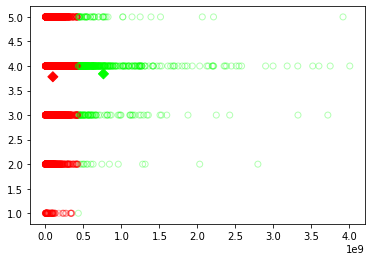

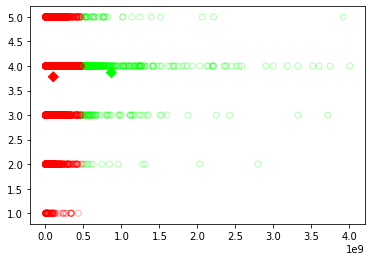

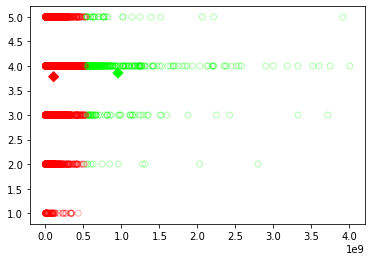

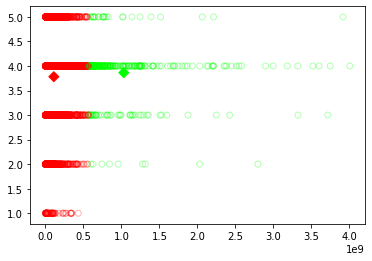

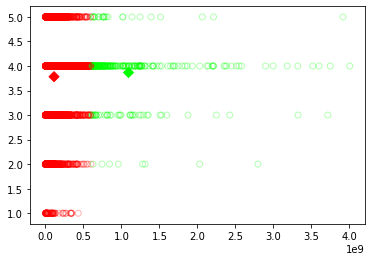

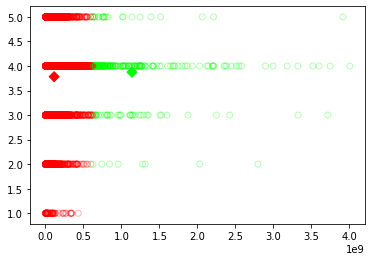

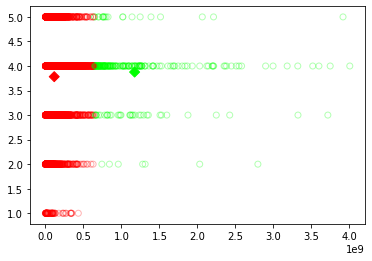

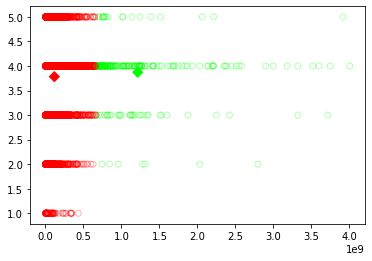

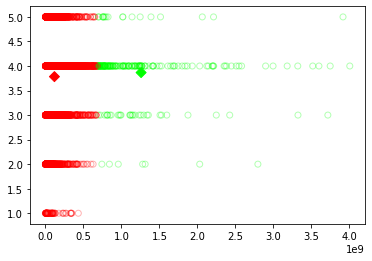

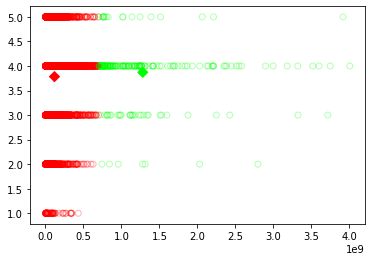

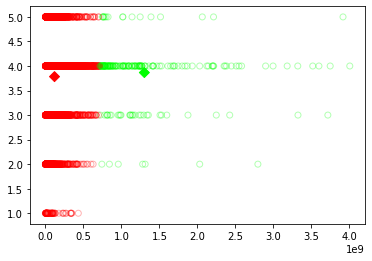

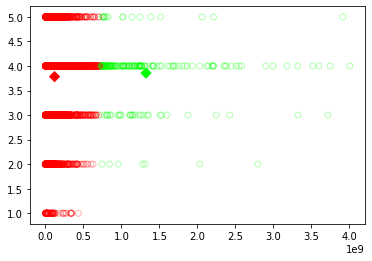

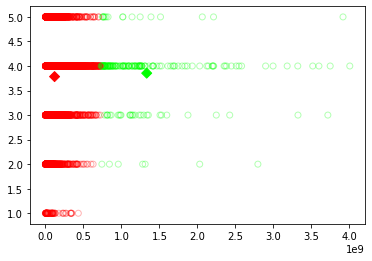

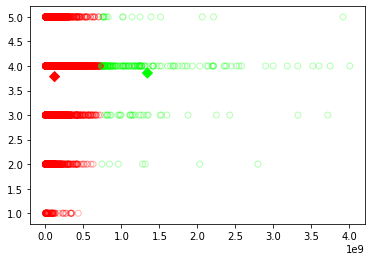

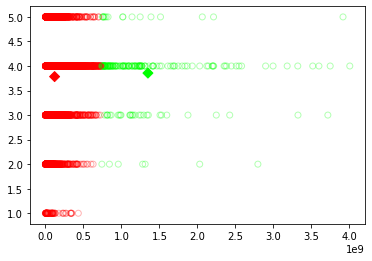

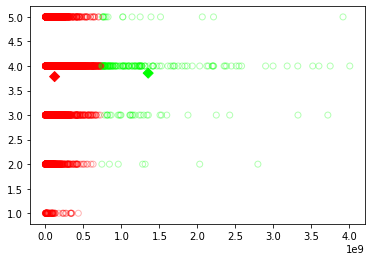

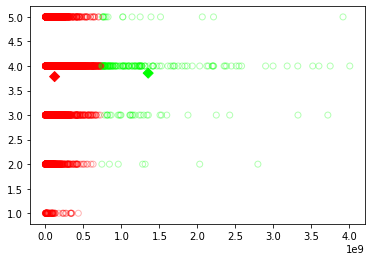

In [15]:
runKMeans(2, df_games, ["Size", "Average User Rating"]) 